In [ ]:
import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def get_optimized_model(num_classes=2):
    # 1. Charger ResNet18 avec des poids pré-entraînés sur ImageNet
    # Ces poids savent déjà reconnaître des formes, des textures, des contrastes.
    resnet = models.resnet18(weights='IMAGENET1K_V1')
    
    # 2. "Freezer" les couches de base (Optionnel au début)
    # On ne ré-entraîne pas tout pour gagner du temps
    for param in resnet.parameters():
        param.requires_grad = False
        
    # 3. Modifier la dernière couche (le "Head")
    # ResNet finit par 512 neurones, on le connecte à nos 2 classes
    num_ftrs = resnet.fc.in_features
    resnet.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    
    return resnet.to(device)

In [3]:
path = "/kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia"

# Petit test pour être sûr que les dossiers sont là
if os.path.exists(path):
    print("✅ Dataset trouvé !")
    print("Dossiers disponibles :", os.listdir(path))
else:
    print("❌ Dataset non trouvé. Vérifie si tu as cliqué sur '+ Add Data' à droite.")

✅ Dataset trouvé !
Dossiers disponibles : ['chest_xray']


In [6]:
BATCH_SIZE = 64
checkpoint = torch.load("/kaggle/input/datasets/asthehis/baseline-pneumonia-model/baseline_metrics.pt")
MEAN = checkpoint['mean']
STD = checkpoint['std']

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

base_path = os.path.join(path, "chest_xray")
full_train = datasets.ImageFolder(os.path.join(base_path, "train"), transform=train_tf)
train_clean = datasets.ImageFolder(os.path.join(base_path, "train"), transform=val_test_tf)
test_dataset = datasets.ImageFolder(os.path.join(base_path, "test"), transform=val_test_tf)

indices = torch.randperm(len(full_train), generator=torch.Generator().manual_seed(42))
train_idx, val_idx = indices[:int(0.9*len(full_train))], indices[int(0.9*len(full_train)):]

train_loader = DataLoader(Subset(full_train, train_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(ConcatDataset([datasets.ImageFolder(os.path.join(base_path, "val"), transform=val_test_tf), 
                                       Subset(train_clean, val_idx)]), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True
)

In [7]:
import matplotlib.pyplot as plt

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5, min_delta=0):
    best_val_loss = float('inf')
    trigger_times = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        
        print(f"\nÉpoque {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / total_train
        
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = 100 * correct_val / total_val
        
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # --- LOGIQUE EARLY STOPPING AMÉLIORÉE ---
        # On vérifie si l'amélioration dépasse le min_delta
        if val_loss < (best_val_loss - min_delta):
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✅ Amélioration significative ! Modèle sauvegardé.")
        else:
            trigger_times += 1
            print(f"⚠️ Pas d'amélioration notable ({trigger_times}/{patience})")
            print(f"   (Best Loss: {best_val_loss:.4f})")
            
            if trigger_times >= patience:
                print(f"🛑 STOP : Pas d'amélioration depuis {patience} époques.")
                break
        # ... (après le calcul de val_loss)
        val_loss = running_val_loss / len(val_loader.dataset)
        
        # AJOUT POUR LE THÈME 3 : Mise à jour du Learning Rate
        scheduler.step(val_loss) 
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate actuel : {current_lr}")

    plot_training_curves(history)
    return history
    

def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'o-', label='Train')
    plt.plot(epochs, history['val_loss'], 'o-', label='Val')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'o-', label='Train')
    plt.plot(epochs, history['val_acc'], 'o-', label='Val')
    plt.title('Accuracy (%)')
    plt.legend()
    
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Lancement de l'entraînement

Époque 1/45


Training: 100%|██████████| 74/74 [00:55<00:00,  1.34it/s]


Train Loss: 0.4964 | Val Loss: 0.3129 | Val Acc: 87.92%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 2/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.84it/s]


Train Loss: 0.2905 | Val Loss: 0.2423 | Val Acc: 88.29%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 3/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.84it/s]


Train Loss: 0.2331 | Val Loss: 0.1833 | Val Acc: 91.82%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 4/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.80it/s]


Train Loss: 0.2081 | Val Loss: 0.1954 | Val Acc: 90.33%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1833)
Learning Rate actuel : 0.0001

Époque 5/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1902 | Val Loss: 0.1785 | Val Acc: 91.64%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 6/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1836 | Val Loss: 0.1544 | Val Acc: 92.75%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 7/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.84it/s]


Train Loss: 0.1703 | Val Loss: 0.1500 | Val Acc: 92.75%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 8/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1672 | Val Loss: 0.1616 | Val Acc: 92.38%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1500)
Learning Rate actuel : 0.0001

Époque 9/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.80it/s]


Train Loss: 0.1761 | Val Loss: 0.1445 | Val Acc: 93.31%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 10/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1668 | Val Loss: 0.1444 | Val Acc: 93.12%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 11/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1526 | Val Loss: 0.1382 | Val Acc: 93.49%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 12/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.82it/s]


Train Loss: 0.1543 | Val Loss: 0.1373 | Val Acc: 92.94%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 13/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.82it/s]


Train Loss: 0.1444 | Val Loss: 0.1333 | Val Acc: 93.87%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 14/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1386 | Val Loss: 0.1296 | Val Acc: 94.05%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 15/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1538 | Val Loss: 0.1280 | Val Acc: 93.87%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 16/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.82it/s]


Train Loss: 0.1505 | Val Loss: 0.1260 | Val Acc: 94.98%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 17/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.79it/s]


Train Loss: 0.1420 | Val Loss: 0.1307 | Val Acc: 93.87%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1260)
Learning Rate actuel : 0.0001

Époque 18/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.79it/s]


Train Loss: 0.1309 | Val Loss: 0.1242 | Val Acc: 94.42%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 19/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1323 | Val Loss: 0.1226 | Val Acc: 94.42%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 20/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.79it/s]


Train Loss: 0.1435 | Val Loss: 0.1273 | Val Acc: 93.68%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1226)
Learning Rate actuel : 0.0001

Époque 21/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.80it/s]


Train Loss: 0.1397 | Val Loss: 0.1318 | Val Acc: 93.12%
⚠️ Pas d'amélioration notable (2/7)
   (Best Loss: 0.1226)
Learning Rate actuel : 0.0001

Époque 22/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.79it/s]


Train Loss: 0.1344 | Val Loss: 0.1216 | Val Acc: 94.98%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 23/45


Training: 100%|██████████| 74/74 [00:39<00:00,  1.85it/s]


Train Loss: 0.1351 | Val Loss: 0.1218 | Val Acc: 94.61%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1216)
Learning Rate actuel : 0.0001

Époque 24/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1324 | Val Loss: 0.1187 | Val Acc: 95.54%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 25/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Train Loss: 0.1342 | Val Loss: 0.1313 | Val Acc: 92.75%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1187)
Learning Rate actuel : 0.0001

Époque 26/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1313 | Val Loss: 0.1218 | Val Acc: 94.61%
⚠️ Pas d'amélioration notable (2/7)
   (Best Loss: 0.1187)
Learning Rate actuel : 0.0001

Époque 27/45


Training: 100%|██████████| 74/74 [00:39<00:00,  1.86it/s]


Train Loss: 0.1291 | Val Loss: 0.1159 | Val Acc: 95.17%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 28/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1387 | Val Loss: 0.1229 | Val Acc: 94.24%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1159)
Learning Rate actuel : 0.0001

Époque 29/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1257 | Val Loss: 0.1147 | Val Acc: 95.72%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 30/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.84it/s]


Train Loss: 0.1384 | Val Loss: 0.1175 | Val Acc: 94.98%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1147)
Learning Rate actuel : 0.0001

Époque 31/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.82it/s]


Train Loss: 0.1241 | Val Loss: 0.1146 | Val Acc: 95.54%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 32/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1208 | Val Loss: 0.1145 | Val Acc: 95.72%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 0.0001

Époque 33/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1281 | Val Loss: 0.1149 | Val Acc: 95.91%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1145)
Learning Rate actuel : 0.0001

Époque 34/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.85it/s]


Train Loss: 0.1286 | Val Loss: 0.1146 | Val Acc: 95.35%
⚠️ Pas d'amélioration notable (2/7)
   (Best Loss: 0.1145)
Learning Rate actuel : 0.0001

Époque 35/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1300 | Val Loss: 0.1185 | Val Acc: 95.91%
⚠️ Pas d'amélioration notable (3/7)
   (Best Loss: 0.1145)
Learning Rate actuel : 5e-05

Époque 36/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.85it/s]


Train Loss: 0.1139 | Val Loss: 0.1110 | Val Acc: 95.35%
✅ Amélioration significative ! Modèle sauvegardé.
Learning Rate actuel : 5e-05

Époque 37/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1227 | Val Loss: 0.1150 | Val Acc: 95.17%
⚠️ Pas d'amélioration notable (1/7)
   (Best Loss: 0.1110)
Learning Rate actuel : 5e-05

Époque 38/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.84it/s]


Train Loss: 0.1245 | Val Loss: 0.1126 | Val Acc: 95.35%
⚠️ Pas d'amélioration notable (2/7)
   (Best Loss: 0.1110)
Learning Rate actuel : 5e-05

Époque 39/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1191 | Val Loss: 0.1116 | Val Acc: 95.54%
⚠️ Pas d'amélioration notable (3/7)
   (Best Loss: 0.1110)
Learning Rate actuel : 2.5e-05

Époque 40/45


Training: 100%|██████████| 74/74 [00:41<00:00,  1.80it/s]


Train Loss: 0.1264 | Val Loss: 0.1144 | Val Acc: 95.17%
⚠️ Pas d'amélioration notable (4/7)
   (Best Loss: 0.1110)
Learning Rate actuel : 2.5e-05

Époque 41/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.81it/s]


Train Loss: 0.1238 | Val Loss: 0.1122 | Val Acc: 95.72%
⚠️ Pas d'amélioration notable (5/7)
   (Best Loss: 0.1110)
Learning Rate actuel : 2.5e-05

Époque 42/45


Training: 100%|██████████| 74/74 [00:39<00:00,  1.85it/s]


Train Loss: 0.1201 | Val Loss: 0.1142 | Val Acc: 95.91%
⚠️ Pas d'amélioration notable (6/7)
   (Best Loss: 0.1110)
Learning Rate actuel : 1.25e-05

Époque 43/45


Training: 100%|██████████| 74/74 [00:40<00:00,  1.83it/s]


Train Loss: 0.1134 | Val Loss: 0.1126 | Val Acc: 95.54%
⚠️ Pas d'amélioration notable (7/7)
   (Best Loss: 0.1110)
🛑 STOP : Pas d'amélioration depuis 7 époques.


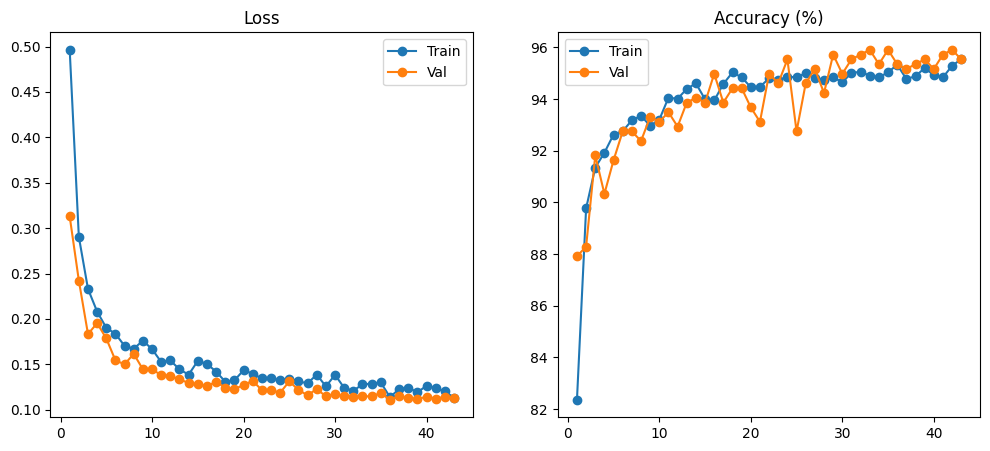

In [8]:
model_resnet = get_optimized_model()

optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-4) # LR plus petit pour le Fine-tuning
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# S'assurer que le writer est prêt pour le Thème 3
writer = SummaryWriter('runs/resnet_theme3_optimization')
weights = torch.tensor([2.8, 1.0]).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights)

print("Lancement de l'entraînement")

# On utilise ta fonction avec une patience un peu plus large (7) 
# car le Transfer Learning peut mettre 1 ou 2 époques à se stabiliser
history = train_model_with_early_stopping(
    model=model_resnet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=45, 
    patience=7
)

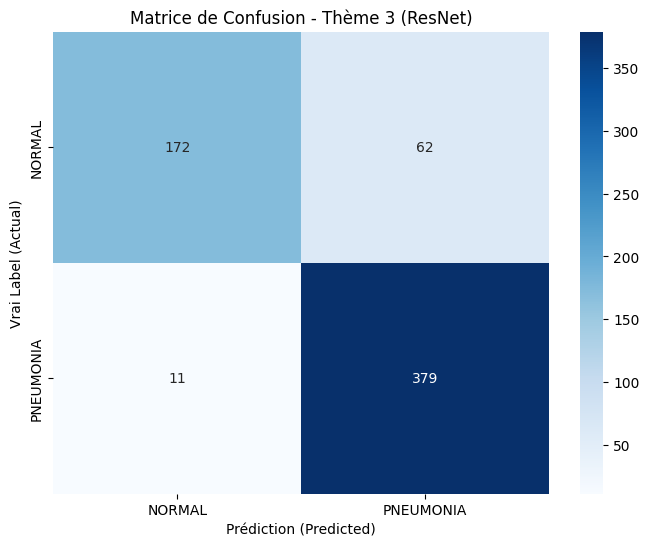


--- Rapport de Classification ---
              precision    recall  f1-score   support

      NORMAL       0.94      0.74      0.82       234
   PNEUMONIA       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def test_model_visual(model, test_loader, device=device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 1. Calcul de la matrice
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ['NORMAL', 'PNEUMONIA'] # L'ordre dépend de tes dossiers

    # 2. Affichage graphique
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title('Matrice de Confusion - Thème 3 (ResNet)')
    plt.ylabel('Vrai Label (Actual)')
    plt.xlabel('Prédiction (Predicted)')
    plt.show()

    # 3. Rapport de classification classique
    print("\n--- Rapport de Classification ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Lancement
test_model_visual(model_resnet, test_loader)